In [1]:
import sys
sys.path.append("C:/Users/User/Desktop/hopfield-izhikevich/hopfield")
from hopfield import Hopfield
# import hopfield

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
from pprint import pprint
from tqdm.notebook import tqdm
from typing import Callable
import numpy
import itertools as it

In [3]:
import pandas as pd

In [4]:
def load_dir(dataset: list, path: str, label: bool, sort=True):
    dataset.sort(key=lambda e: e["id"])
    if dataset:
        index = dataset[-1]["id"]+1
    else:
        index = 0
    fnames = [(path+"/Red/"+i[:2]+"_Red.txt", path+"/Green/"+i[:2]+"_Green.txt",path+"/Blue/"+i[:2]+"_Blue.txt") for i in [i for i in os.walk(path)][1][2]]
    for fname in fnames:
        person = {"id": index}
        person["label"] = label
        with open(fname[0],"r") as rfile, open(fname[1],"r") as gfile, open(fname[2],"r") as bfile:
            person["r"] = [float(i) for i in rfile.readlines()[1:]]
            person["g"] = [float(i) for i in gfile.readlines()[1:]]
            person["b"] = [float(i) for i in bfile.readlines()[1:]]
        
        if sort:
            person["r"].sort()
            person["g"].sort()            
            person["b"].sort()
        
        index+=1
        dataset.append(person)
        
def load_dataset(dataset: list, path: str, pathpos: str, pathneg: str, sort=True):
    load_dir(dataset, path+"/"+pathpos, True, sort=sort)
    load_dir(dataset, path+"/"+pathneg, False, sort=sort)    
        
        
# def get_filter(dataset: list, filter: str):
#     if filter!="r" and filter!="g" and filter!="b":
#         raise ValueError('Wrong filter: must be "r", "g", "b"')
#     new_dataset = []
#     for person in dataset:
#         new_dataset.append({"id": person["id"], "label": person["label"], "data": person[filter]})
    
#     return new_dataset

def show_plot_by_filter(dataset: list, filter: str):
    plt.clf()
    if filter!="r" and filter!="g" and filter!="b":
        raise ValueError('Wrong filter: must be "r", "g", "b"')
    for i in np.arange(0,len(dataset), 1):
        color="green"
        if dataset[i]["label"]:
            color="red"
        for j in dataset[i][filter]:
            plt.plot(i,j, "o", markersize=0.5, color=color)
    plt.show()

    
def binarize_person(person: dict, precision=1e-3, up=1.8, down=0.2, radius=0, flatten=True, filters=3):
    person_data = np.zeros((3, int((up-down)//precision)+1), np.float32)[0:filters]
    
    dots  = (
        ((np.array(person["r"]).clip(down, up)-down)//precision).astype(np.uint32),
        ((np.array(person["g"]).clip(down, up)-down)//precision).astype(np.uint32),
        ((np.array(person["b"]).clip(down, up)-down)//precision).astype(np.uint32))[0:filters]
#     r = np.array(person["r"])
#     g = np.array(person["g"])
#     b = np.array(person["b"])
    
    
#     dots  = (
#         ((r[up>r & r>down]-down)//precision).astype(np.uint32),
#         (([up>g & g>down]-down)//precision).astype(np.uint32),
#         (([up>b & b>down]-down)//precision).astype(np.uint32))[0:filters]
    
    
    
    for color_index in range(filters):
        for dot in dots[color_index]:
            person_data[color_index][max(0, dot-radius) : min(dot+radius+1, person_data.shape[1])].fill(1)
    
    if flatten:
        return {"id": person["id"], "label": person["label"], "data": person_data.flatten()}
    else:
        return {"id": person["id"], "label": person["label"], "data": person_data}

def show_plot_avg_by_filter(dataset: list, filter: str):
    plt.clf()
    if filter!="r" and filter!="g" and filter!="b":
        raise ValueError('Wrong filter: must be "r", "g", "b"')
    for person in dataset:
        
        if person["label"]:
            color="red"
            x = 0
        else:
            color="green"
            x = 1
             
        for y in person[filter]:
            plt.plot(x,y, "o", markersize=0.5, color=color)
    plt.show()
    


In [5]:
def diceScore(a: np.ndarray, b: np.ndarray):
    if(len(a)!=len(b)):
        raise IndexError 
    tp = 0
    for i in range(min(len(a), len(b))):
        if a[i]>0 and b[i]>0:
            tp+=1
    return 2*tp/(sum(a>0)+sum(b>0))

In [6]:
def fullMatch(a: np.ndarray, b: np.ndarray):
    if(len(a)!=len(b)):
        raise IndexError 
    tp = 0
    for i in range(min(len(a), len(b))):
        if (a[i]>0 and b[i]>0) or (a[i]<0 and b[i]<0):
            tp+=1
    return tp/(len(a))

In [7]:
diceScore(np.array([1,1,1,1,-1]),np.array([1,-1,-1,1,-1]))

0.6666666666666666

In [8]:
def max_score_i(dataset: np.ndarray, X: np.ndarray, i: int, score_fn: Callable):
    if i==0:
        max_i = 1
    else:
        max_i = 0
    # print(f"len {len(dataset)}")
    for j in (k for k in range(len(dataset)) if k!=i):
        if score_fn(X,dataset[max_i]) <= score_fn(X,dataset[j]):
            max_i = j
            
    return max_i

In [9]:
def cartesian_product(*arrays):
    la = len(arrays)
    dtype = numpy.result_type(*arrays)
    arr = numpy.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(numpy.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

In [10]:
dataset = []
load_dataset(dataset, "data_orig/Data", "BC", "Control")

## One-leave-out with dice score

In [45]:
q_range=(0,0.6,7)
r_range=(10,50,9)
q = np.linspace(*q_range, dtype=np.float32)
r = np.linspace(*r_range,dtype=int)
tests = list(it.product(q,r))
_dataset=dataset[39:]

In [47]:
filters=1

time=500
dtype=np.float32

test_result=[]

for q,r in tqdm(tests):
    result = []
    answer = []
    maxs = []
    dataset_bin = [binarize_person(p, precision=1e-4, radius=r, filters=filters, down=0.8, up=1.1) for p in _dataset]
    raw_data = np.array([i["data"]*2-1 for i in dataset_bin], dtype=dtype)

    for i in tqdm(range(len(_dataset))):
        model = Hopfield(q=q, np_type=dtype)
        _mask = np.ones(len(dataset_bin), dtype=bool)
        _mask[i] = False

        _X = raw_data[i]
        _images = raw_data[_mask]


        model.train(images=_images, zeroDiagonal=True)
        out = model.run(X=_X, time=time)


        max_i = max_score_i(dataset=raw_data, X=out["output"], i=i, score_fn=diceScore)
        maxs.append(max_i)


        answer.append(dataset_bin[max_i]["label"])
        if dataset_bin[max_i]["label"]==dataset_bin[i]["label"]:
            result.append(1)
        else:
            result.append(0)
            
    score = sum(result)/len(_dataset)
    test_result.append({"q":q,"r":r, "score":score, "result":result, "maxs":maxs})
    print("qr",(q,r), " score ",score)
    



  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.0, 10)  score  0.5


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.0, 15)  score  0.5


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.0, 20)  score  0.5517241379310345


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.0, 25)  score  0.5517241379310345


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.0, 30)  score  0.43103448275862066


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.0, 35)  score  0.46551724137931033


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.0, 40)  score  0.5172413793103449


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.0, 45)  score  0.603448275862069


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.0, 50)  score  0.4482758620689655


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.1, 10)  score  0.5172413793103449


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.1, 15)  score  0.5


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.1, 20)  score  0.5344827586206896


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.1, 25)  score  0.6206896551724138


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.1, 30)  score  0.5172413793103449


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.1, 35)  score  0.4827586206896552


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.1, 40)  score  0.4827586206896552


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.1, 45)  score  0.5172413793103449


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.1, 50)  score  0.5172413793103449


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.2, 10)  score  0.5


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.2, 15)  score  0.5


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.2, 20)  score  0.5689655172413793


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.2, 25)  score  0.5517241379310345


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.2, 30)  score  0.46551724137931033


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.2, 35)  score  0.46551724137931033


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.2, 40)  score  0.4827586206896552


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.2, 45)  score  0.5172413793103449


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.2, 50)  score  0.5


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.3, 10)  score  0.4827586206896552


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.3, 15)  score  0.5


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.3, 20)  score  0.5517241379310345


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.3, 25)  score  0.6379310344827587


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.3, 30)  score  0.5517241379310345


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.3, 35)  score  0.4482758620689655


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.3, 40)  score  0.43103448275862066


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.3, 45)  score  0.4827586206896552


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.3, 50)  score  0.5517241379310345


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.4, 10)  score  0.4827586206896552


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.4, 15)  score  0.4827586206896552


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.4, 20)  score  0.5344827586206896


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.4, 25)  score  0.5862068965517241


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.4, 30)  score  0.5172413793103449


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.4, 35)  score  0.5


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.4, 40)  score  0.5


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.4, 45)  score  0.4827586206896552


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.4, 50)  score  0.4827586206896552


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.5, 10)  score  0.5


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.5, 15)  score  0.5


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.5, 20)  score  0.5689655172413793


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.5, 25)  score  0.603448275862069


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.5, 30)  score  0.4827586206896552


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.5, 35)  score  0.5172413793103449


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.5, 40)  score  0.5


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.5, 45)  score  0.4827586206896552


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.5, 50)  score  0.46551724137931033


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.6, 10)  score  0.5


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.6, 15)  score  0.5


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.6, 20)  score  0.5862068965517241


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.6, 25)  score  0.5


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.6, 30)  score  0.5172413793103449


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.6, 35)  score  0.4482758620689655


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.6, 40)  score  0.4827586206896552


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.6, 45)  score  0.5


  0%|          | 0/58 [00:00<?, ?it/s]

qr (0.6, 50)  score  0.5862068965517241


In [87]:
pd.DataFrame(test_result).to_csv("test_results/test_2_result.csv", index=False)

In [85]:
from mayavi import mlab

X, Y, Z = [], [], []
for i in test_result:
    X.append(i["q"])
    Y.append(i["r"]/100)
    Z.append(i["score"])


pts = mlab.points3d(X, Y, Z, Z)
mesh = mlab.pipeline.delaunay2d(pts)
pts.remove()
surf = mlab.pipeline.surface(mesh)
mlab.xlabel("Q")
mlab.ylabel("Radius")
mlab.zlabel("%")
mlab.show()

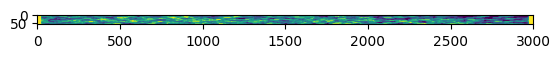

(58, 3001)
coef: 0.019326891036321226


  0%|          | 0/58 [00:00<?, ?it/s]

3 0 3 0 0 1 4 31 0 1 12 14 0 0 5 0 0 0 1 0 2 0 0 0 0 2 0 2 1 9 4 37 7 3 3 0 8 36 31 11 6 0 31 37 42 31 11 1 1 2 0 11 0 44 6 8 11 5 
0.6206896551724138


In [17]:
q=0
radius=25
#0 25 0.65 10-4

filters=1

time=500
dtype=np.float32

result = []
answer = []
maxs = []

dataset_bin = [binarize_person(p, precision=1e-4, radius=radius, filters=filters, down=0.8, up=1.1) for p in _dataset]
raw_data = np.array([i["data"]*2-1 for i in dataset_bin], dtype=dtype)

plt.imshow(raw_data)
plt.show()
print(raw_data.shape)
print(f"coef: {raw_data.shape[0]/raw_data.shape[1]}")


for i in tqdm(range(len(_dataset))):
    model = Hopfield(q=q, np_type=dtype)
    _mask = np.ones(len(dataset_bin), dtype=bool)
    _mask[i] = False

    _X = raw_data[i]
    _images = raw_data[_mask]

    
    model.train(images=_images, zeroDiagonal=True)
    out = model.run(X=_X, time=time)
    
    max_i = max_score_i(dataset=raw_data, X=out["output"], i=i, score_fn=diceScore)
    maxs.append(max_i)
    
    print(max_i, end=" ")
    
    answer.append(dataset_bin[max_i]["label"])
    if dataset_bin[max_i]["label"]==dataset_bin[i]["label"]:
        result.append(1)
    else:
        result.append(0)
    
print("")
score = sum(result)/len(_dataset)
print(score)